In [2]:
import os
import pypsa
import numpy as np
import pandas as pd
from pathlib import Path

In [5]:
bmus_fn = Path.cwd().parent / 'data' / 'bmus_prepared.csv'
wholesale_prices_fn = Path.cwd().parent / 'resources' / 'thermal_costs' / '2022-09.csv'
cfd_strike_prices_fn = Path.cwd().parent / 'resources' / 'cfd_strike_prices.csv'
roc_values_fn = Path.cwd().parent / 'data' / 'roc_values.csv'
nuclear_marginal_price_fn = Path.cwd().parent / 'data' / 'nuclear_marginal_cost.csv'
battery_phs_capacities_fn = Path.cwd().parent / 'data' / 'battery_phs_capacities.csv'

pn_fn = str(Path.cwd().parent / 'data' / 'base' / '{}' / 'physical_notifications.csv')
mel_fn = str(Path.cwd().parent / 'data' / 'base' / '{}' / 'maximum_export_limits.csv')

In [4]:
bmus = pd.read_csv(bmus_fn, index_col=0)

C:\Users\lukas\AppData\Local\Temp\ipykernel_34180\2082730147.py:250: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.read_csv(cfd_strike_prices_fn, index_col=0, parse_dates=True)


Adding 97 onwind generators...
Adding 68 offwind generators...
Adding 0 solar generators...
Adding 9 nuclear generators...
Adding 106 thermal generators...
Index(['CRUA-1', 'CRUA-2', 'CRUA-3', 'CRUA-4', 'DINO-1', 'DINO-6', 'FFES-1',
       'FFES-3', 'FFES-4', 'FOYE-1', 'FOYE-2', 'FOYED-1', 'DINO-5', 'DINO-4',
       'FFES-2', 'DINO-3', 'DINO-2'],
      dtype='object', name='NationalGridBmUnit')
Adding 17 pumped hydro storage units...


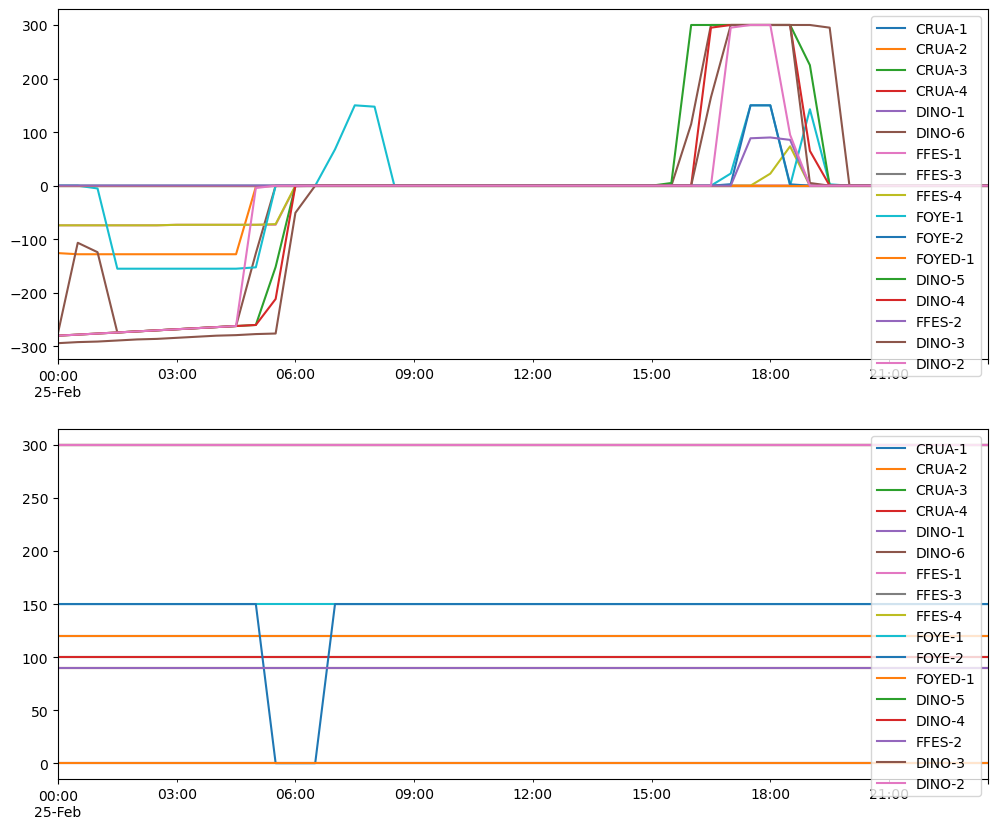

In [13]:
def add_wind(
        n,
        bmus,
        pn,
        mel,
        cfds,
        rocs,
        carrier=None,
    ):

    plants = (
        bmus[bmus['carrier'] == carrier]
        .index
        .intersection(pn.columns)
    )

    print(f'Adding {len(plants)} {carrier} generators...')

    n.add(
        "Generator",
        plants,
        bus='bus',
        carrier='onwind',
        p_nom=pn[plants].max(),
        marginal_cost=np.nan,
        efficiency=1,
        p_max_pu=pn[plants].div(pn[plants].max()),
    )

    roc_generators = rocs.index.intersection(plants)
    n.generators.loc[roc_generators, 'marginal_cost'] = - rocs[roc_generators]

    cfd_generators = cfds.index.intersection(plants)
    n.generators.loc[cfd_generators, 'marginal_cost'] = 0.


def add_onshore_wind(*args):
    add_wind(*args, carrier='onwind')


def add_offshore_wind(*args):
    add_wind(*args, carrier='offwind')


def add_solar(
        n,
        bmus,
        pn,
    ):

    plants = (
        bmus[bmus['carrier'] == 'solar']
        .index
        .intersection(pn.columns)
    )

    print(f'Adding {len(plants)} solar generators...')

    n.add(
        "Generator",
        plants,
        bus='bus',
        carrier='solar',
        p_nom=pn[plants].max(),
        marginal_cost=0.,
        efficiency=1,
        p_max_pu=pn[plants].div(pn[plants].max()),
    )


def add_nuclear(
        n,
        bmus,
        pn,
        nuclear_wholesale_price,
    ):

    plants = bmus[bmus['carrier'] == 'nuclear'].index

    # some nuclear-labelled BMUs always import electricity
    # these are thrown out
    plants = plants.intersection(pn.columns[pn.mean() > 0])

    print(f'Adding {len(plants)} nuclear generators...')
    n.add(
        "Generator",
        plants,
        bus='bus',
        carrier='nuclear',
        p_nom=pn[plants].max(),
        marginal_cost=nuclear_wholesale_price,
        efficiency=1,
    )

    # For nuclear units that are not constant, a 'p_max_pu' is needed
    for plant in plants:
        if len(pn[plant].unique()) > 1:
            n.generators_t['p_max_pu'].loc[:,plant] = pn[plant].div(pn[plant].max())


def add_thermal(
        n,
        bmus,
        pn,
        mel,
        wholesale_prices,
    ):

    plants = (
        bmus[bmus['carrier'].isin(['biomass', 'fossil'])]
        .index
        .intersection(pn.columns)
        .intersection(mel.columns)
    )
    print(f'Adding {len(plants)} thermal generators...')

    assert plants.isin(wholesale_prices.index).all(), 'Missing wholesale prices for some thermal plants.'    

    n.add(
        "Generator",
        plants,
        bus='bus',
        carrier=bmus.loc[plants, 'carrier'],
        p_nom=mel[plants].max(),
        marginal_cost=wholesale_prices.loc[plants],
        p_max_pu=mel[plants].div(mel[plants].max()),
    )


def add_batteries(
        n,
        bmus,
        pn,
        mel,
        battery_capacities,
        ):

    batteries = bmus[bmus['carrier'] == 'battery'].index

    batteries = batteries.intersection(pn.columns).intersection(mel.columns)

    # times two because time step is 30 minutes and max_hours does not
    # refer to hours but time steps within the context of the network's
    # time scale
    max_hours = (
        battery_capacities['energy_cap[MWh]']
        .div(battery_capacities['power_cap[MW]'])
        .mul(2.)
    )

    n.add(
        "StorageUnit",
        batteries,
        bus='bus',
        p_nom=battery_capacities.loc[batteries, 'power_cap[MW]'],
        max_hours=max_hours.loc[batteries],
        marginal_cost=0.,
        e_cyclic=True,
        state_of_charge_initial=(
            battery_capacities
            .loc[batteries, 'energy_cap[MWh]']
            .div(3.)
        ),
    )


def add_pumped_hydro(
    n,
    bmus,
    pn,
    mel,
    ):
    phs = bmus[bmus['carrier'] == 'PHS'].index
    print(phs)

    print(f'Adding {len(phs)} pumped hydro storage units...')

    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(2, 1, figsize=(12, 10))

    pn[phs].plot(ax=ax[0])
    mel[phs].plot(ax=ax[1])
    plt.show()




def add_cascade():
    raise NotImplementedError

def add_dispatchable_hydro():
    raise NotImplementedError

def add_interconnectors():
    raise NotImplementedError


def build_static_supply_curve(
        n,
        bmus,
        pn,
        mel,
        wholesale_prices,
        cfd_strike_prices,
        roc_values,
        nuclear_wholesale_price,
        battery_capacities,
    ):
    """
    Builds one day of available power plants, storage units and their marginal costs.
    It is 'static' in not scaling marginal costs according to wholesale price (yet).
    """

    n.generators.loc[:, 'marginal_cost'] = np.nan
    n.storage_units.loc[:, 'marginal_cost'] = np.nan

    add_onshore_wind(n, bmus, pn, mel, cfd_strike_prices, roc_values)
    add_offshore_wind(n, bmus, pn, mel, cfd_strike_prices, roc_values)
    add_solar(n, bmus, pn)
    add_nuclear(n, bmus, pn, nuclear_wholesale_price)
    add_thermal(n, bmus, pn, mel, wholesale_prices)
    add_batteries(n, bmus, pn, mel, battery_capacities)
    add_pumped_hydro(n, bmus, pn, mel)




if __name__ == '__main__':

    n = pypsa.Network()

    n.add("Bus", "bus")

    day = '2022-02-25'

    pn = pd.read_csv(pn_fn.format(day), index_col=0, parse_dates=True)
    mel = pd.read_csv(mel_fn.format(day), index_col=0, parse_dates=True)

    pn.index = pn.index.values
    mel.index = mel.index.values

    n.set_snapshots(pn.index)

    wholesale_prices = (
        pd.read_csv(wholesale_prices_fn, index_col=0)
        .iloc[:,0]
    )

    cfd_strike_prices = (
        pd.read_csv(cfd_strike_prices_fn, index_col=0, parse_dates=True)
        .loc[:, :day]
        .iloc[:, -1]
        .rename('cfd_strike_price')
    )

    roc_values_fn = Path.cwd().parent / 'data' / 'roc_values.csv'
    roc_values = (
        pd.read_csv(roc_values_fn, index_col=0)
        .iloc[:,0]
        .rename('roc_value')
    )

    nuclear_wholesale_price = pd.read_csv(nuclear_marginal_price_fn, index_col=0).iloc[0,0]

    battery_capacities = pd.read_csv(battery_capacities_fn, index_col=0)



    build_static_supply_curve(
        n,
        bmus,
        pn,
        mel,
        wholesale_prices,
        cfd_strike_prices,
        roc_values,
        nuclear_wholesale_price,
        battery_capacities,
        )



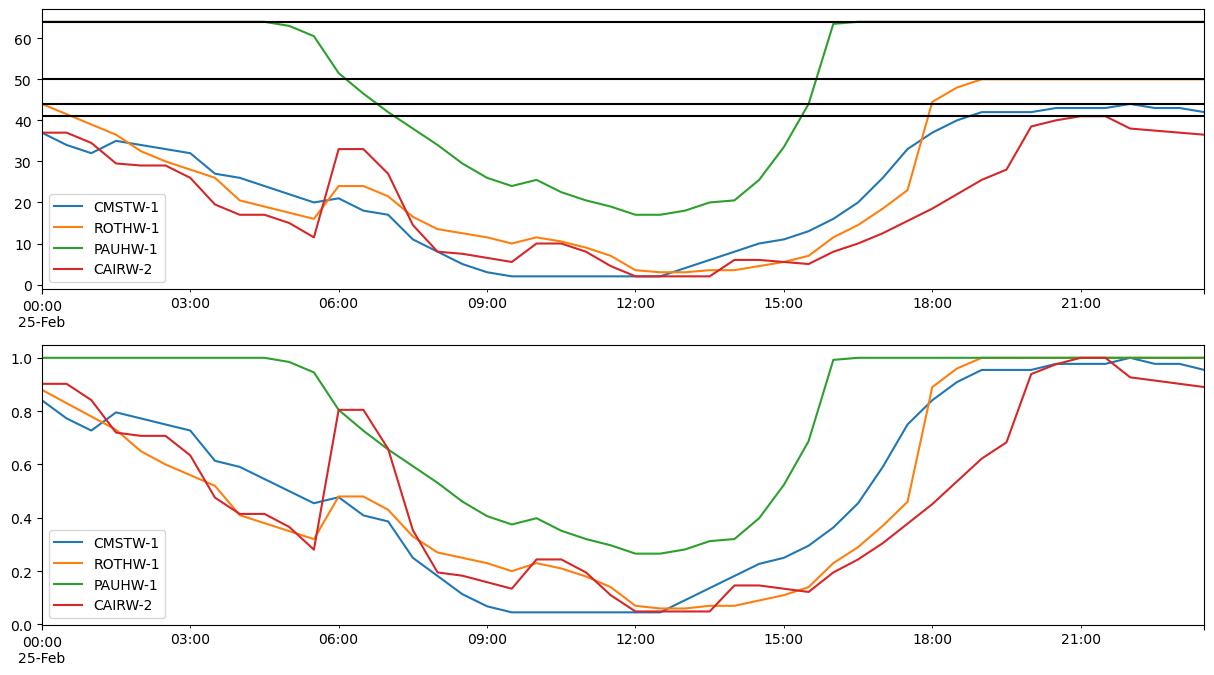

In [25]:
import matplotlib.pyplot as plt

onshore = bmus[bmus['carrier'] == 'onwind'].index.intersection(pn.columns).intersection(mel.columns)[:4]

fig, axs = plt.subplots(2, 1, figsize=(15, 8))

pn.loc[:, onshore].plot(ax=axs[0])
for i in onshore:
    axs[0].axhline(pn[i].max(), color='black')

normalised_pn = pn[onshore].div(pn[onshore].max())
normalised_pn.loc[:, onshore].plot(ax=axs[1])

plt.show()